# Wimbledon Featured Matches: Initial EDA Roadmap

This notebook rebuilds the exploratory data analysis per the README guidance while keeping every figure inline for rapid iteration.

## 1. Environment Setup and Library Imports

We configure the analysis environment, import required libraries, and define reusable paths without saving any figures to disk.

In [1]:
# Core data manipulation and numerical computing
import pandas as pd
import numpy as np

# Visualization libraries for inline plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File-system handling
from pathlib import Path

# Math utilities for Wilson confidence intervals (keeps notebook self-contained)
from math import sqrt

def wilson_confidence_interval(successes, total, alpha=0.05):
    """Compute the Wilson score interval for a binomial proportion."""
    if total == 0:
        return (np.nan, np.nan)
    if alpha == 0.05:
        z = 1.96
    else:
        from math import erfcinv
        z = sqrt(2) * erfcinv(alpha) * -1
    phat = successes / total
    denominator = 1 + (z ** 2) / total
    centre = phat + (z ** 2) / (2 * total)
    margin = z * sqrt((phat * (1 - phat) + (z ** 2) / (4 * total)) / total)
    lower = (centre - margin) / denominator
    upper = (centre + margin) / denominator
    return lower, upper

# Optional high-performance dataframe engine; fallback gracefully if unavailable
try:
    import polars as pl
    POLARS_AVAILABLE = True
except ImportError:
    POLARS_AVAILABLE = False

# Configure plotting aesthetics for inline-only figures
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14

# Project-level paths
PROJECT_ROOT = Path("/workspaces/Mathematical-Modelling")
DATA_DIR = PROJECT_ROOT / "2024C"
RAW_DATA_PATH = DATA_DIR / "2024_Wimbledon_featured_matches.csv"
ARTEFACT_DIR = DATA_DIR / "artefacts"
DERIVED_DATA_DIR = ARTEFACT_DIR / "derived_data"
DERIVED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Polars available: {POLARS_AVAILABLE}")
print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Derived data directory: {DERIVED_DATA_DIR}")

Polars available: False
Raw data path: /workspaces/Mathematical-Modelling/2024C/2024_Wimbledon_featured_matches.csv
Derived data directory: /workspaces/Mathematical-Modelling/2024C/artefacts/derived_data


## 2. Load Point-By-Point Match Dataset

We ingest the raw CSV, log structural assumptions, and optionally mirror it in Polars for experimentation.

In [2]:
# Validate data availability before loading
if not RAW_DATA_PATH.exists():
    raise FileNotFoundError(f"Expected dataset at {RAW_DATA_PATH}, but it was not found.")

# Configure pandas read to balance memory usage and type fidelity
pandas_read_kwargs = {
    "low_memory": False,
    "memory_map": True
}

points_df = pd.read_csv(RAW_DATA_PATH, **pandas_read_kwargs)
print(f"Loaded {len(points_df):,} rows with {len(points_df.columns)} columns.")

if POLARS_AVAILABLE:
    points_pl = pl.read_csv(RAW_DATA_PATH)
    print(f"Polars frame shape: {points_pl.shape}")
else:
    points_pl = None

display(points_df.head(10))

Loaded 7,284 rows with 46 columns.


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN
5,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:50,1,1,6,0,0,0,...,0,0,0,5.291,4.249,2,97.0,BW,NCTL,ND
6,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:03:33,1,1,7,0,0,0,...,0,0,0,6.817,17.821,1,109.0,W,CTL,D
7,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:04:01,1,1,8,0,0,0,...,0,0,0,17.503,18.067,6,105.0,B,NCTL,ND
8,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:04:48,1,1,9,0,0,0,...,0,0,0,34.489,24.594,7,128.0,BC,CTL,D
9,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:05:32,1,1,10,0,0,0,...,0,0,0,21.235,27.427,5,110.0,B,NCTL,ND


## 3. Data Quality and Schema Validation

We verify schema expectations, inspect dtypes, examine missingness, and confirm chronological ordering assumptions.

In [3]:
# Expected columns grouped per README taxonomy
expected_columns = {
    "contextual": [
        "match_id", "set_no", "game_no", "point_no", "p1_sets", "p2_sets",
        "p1_games", "p2_games", "p1_score", "p2_score"
    ],
    "serve_metrics": [
        "server", "serve_no", "serve_width", "serve_depth", "speed_mph", "return_depth"
    ],
    "physical": [
        "p1_distance_run", "p2_distance_run", "rally_count"
    ],
    "outcome_flags": [
        "point_victor", "p1_winner", "p2_winner", "p1_unforced_error",
        "p2_unforced_error", "p1_double_fault", "p2_double_fault", "break_point"
    ]
}

flat_expected = set(col for cols in expected_columns.values() for col in cols)
missing_columns = flat_expected.difference(points_df.columns)
unexpected_columns = set(points_df.columns).difference(flat_expected)

print("Missing expected columns:", sorted(missing_columns) if missing_columns else "None")
print("Unexpected additional columns (candidate enrichments):", sorted(unexpected_columns))

Missing expected columns: ['break_point', 'p1_unforced_error', 'p2_unforced_error']
Unexpected additional columns (candidate enrichments): ['elapsed_time', 'game_victor', 'p1_ace', 'p1_break_pt', 'p1_break_pt_missed', 'p1_break_pt_won', 'p1_net_pt', 'p1_net_pt_won', 'p1_points_won', 'p1_unf_err', 'p2_ace', 'p2_break_pt', 'p2_break_pt_missed', 'p2_break_pt_won', 'p2_net_pt', 'p2_net_pt_won', 'p2_points_won', 'p2_unf_err', 'player1', 'player2', 'set_victor', 'winner_shot_type']


In [4]:
# Inspect dtypes to confirm categorical versus numeric casting
schema_overview = (
    points_df.dtypes.reset_index()
    .rename(columns={"index": "column", 0: "dtype"})
)
display(schema_overview.head(20))

,column,dtype
0,match_id,object
1,player1,object
2,player2,object
3,elapsed_time,object
4,set_no,int64
5,game_no,int64
6,point_no,int64
7,p1_sets,int64
8,p2_sets,int64
9,p1_games,int64


In [5]:
# Quantify missingness to surface data hygiene concerns early
missing_summary = (
    points_df.isna().sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda df: df["missing_count"] / len(points_df))
    .sort_values("missing_pct", ascending=False)
)
display(missing_summary.head(15))

,missing_count,missing_pct
return_depth,1309,0.179709
speed_mph,752,0.103240
serve_width,54,0.007414
serve_depth,54,0.007414
match_id,0,0.000000
player1,0,0.000000
point_no,0,0.000000
p1_sets,0,0.000000
p2_sets,0,0.000000
p1_games,0,0.000000


In [6]:
# Confirm chronological ordering and inspect duplicate identifiers
sort_columns = ["match_id", "set_no", "game_no", "point_no"]
sorted_df = points_df.sort_values(sort_columns)
if not sorted_df[sort_columns].equals(points_df[sort_columns]):
    print("Warning: chronological order differs from expected sort; consider reindexing.")
else:
    print("Chronological ordering already aligned with expected sequence.")

duplicate_mask = points_df.duplicated(subset=sort_columns, keep=False)
duplicate_points = points_df.loc[duplicate_mask, sort_columns + ["server", "point_victor"]]
print(f"Potential duplicate point identifiers: {len(duplicate_points)}")
if not duplicate_points.empty:
    display(duplicate_points.head())

Chronological ordering already aligned with expected sequence.
Potential duplicate point identifiers: 0


## 3a. Data Coverage Diagnostics
We audit missingness patterns and match-level sample balance to surface potential biases before modeling.

/tmp/ipykernel_7948/2329207255.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_missing, x="missing_pct", y="column", palette="Blues_r", ax=ax)


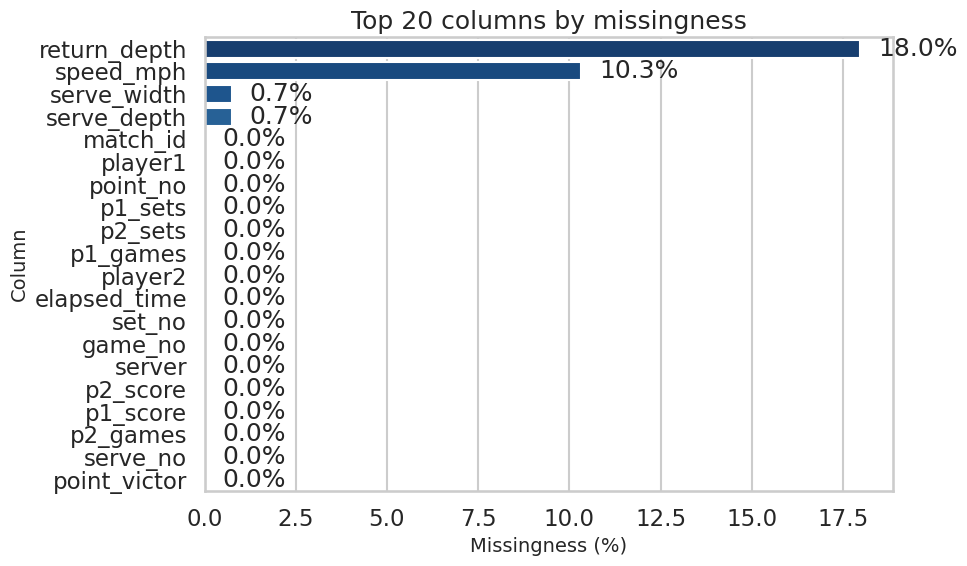

In [7]:
# Visualize column-wise missingness as percentages
missing_pct = (points_df.isna().mean() * 100).sort_values(ascending=False)
missing_df = missing_pct.reset_index().rename(columns={"index": "column", 0: "missing_pct"})

top_missing = missing_df.head(20)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=top_missing, x="missing_pct", y="column", palette="Blues_r", ax=ax)
ax.set_xlabel("Missingness (%)")
ax.set_ylabel("Column")
ax.set_title("Top 20 columns by missingness")
for i, row in top_missing.iterrows():
    ax.text(row["missing_pct"] + 0.5, i, f"{row['missing_pct']:.1f}%", va="center")
plt.tight_layout()
plt.show()

**Figure:** Physical tracking metrics (e.g., return depth) exhibit the heaviest missingness, signalling a need for imputation strategies before modeling fatigue effects.

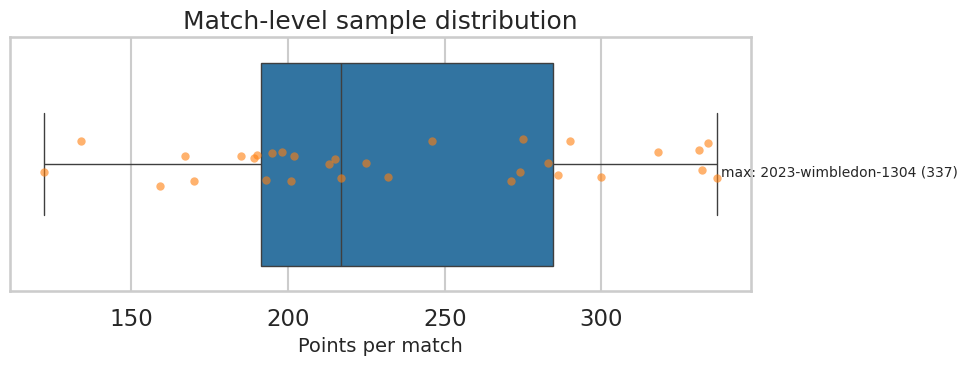

In [8]:
# Match-level sample sizes to expose imbalance across contests
match_point_counts = points_df.groupby("match_id").size().reset_index(name="points")
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=match_point_counts, x="points", ax=ax, color="#1f77b4", fliersize=4)
sns.stripplot(data=match_point_counts, x="points", ax=ax, color="#ff7f0e", alpha=0.6, size=6)
ax.set_xlabel("Points per match")
ax.set_title("Match-level sample distribution")
for _, row in match_point_counts.iterrows():
    if row["points"] == match_point_counts["points"].max():
        ax.text(row["points"] + 1, 0.05, f"max: {row['match_id']} ({row['points']})", fontsize=10)
plt.tight_layout()
plt.show()

**Figure:** Matches vary from short exhibitions to long epics, so downstream modeling and validation should stratify or weight by contest length.

## 4. Contextual Feature Engineering (Score State, Importance)

We normalize server IDs, encode score states, and build point-importance proxies in line with the modeling plan.

In [9]:
# Clone raw frame to preserve original data
points_enriched = points_df.copy()

# Normalize server identifiers to numeric {1, 2}
server_raw = points_enriched["server"].astype(str).str.strip().str.upper()
server_map = {"1": 1, "P1": 1, "PLAYER1": 1, "A": 1, "2": 2, "P2": 2, "PLAYER2": 2, "B": 2}
points_enriched["server_numeric"] = server_raw.map(server_map)

# Encode tennis point scores for arithmetic logic
score_encoding = {"0": 0, "15": 1, "30": 2, "40": 3, "AD": 4}
for col in ["p1_score", "p2_score"]:
    points_enriched[f"{col}_encoded"] = points_enriched[col].astype(str).str.upper().map(score_encoding)

# Detect tiebreaks via explicit flag when present, else fallback heuristic
if "tiebreak" in points_enriched.columns:
    points_enriched["is_tiebreak"] = points_enriched["tiebreak"].astype(bool)
else:
    points_enriched["is_tiebreak"] = points_enriched["point_no"] >= 7

# Compose score-state identifier across sets, games, and point score
points_enriched["score_state_id"] = (
    points_enriched["p1_sets"].astype(str) + "-" + points_enriched["p2_sets"].astype(str) + "_" +
    points_enriched["p1_games"].astype(str) + "-" + points_enriched["p2_games"].astype(str) + "_" +
    points_enriched["p1_score"].astype(str) + "-" + points_enriched["p2_score"].astype(str)
)

# Break-point detection: prefer native flag; otherwise infer from receiver score
if "break_point" in points_enriched.columns:
    points_enriched["is_break_point"] = points_enriched["break_point"].astype(bool)
else:
    receiver_encoded = np.where(
        points_enriched["server_numeric"] == 1,
        points_enriched["p2_score_encoded"],
        points_enriched["p1_score_encoded"]
)
    fallback_receiver = points_enriched[["p1_score_encoded", "p2_score_encoded"]].max(axis=1)
    receiver_encoded = np.where(points_enriched["server_numeric"].isna(), fallback_receiver, receiver_encoded)
    points_enriched["is_break_point"] = receiver_encoded >= 3

# Deuce-or-later flag (excluding tiebreaks)
points_enriched["is_deuce_or_later"] = (
    (~points_enriched["is_tiebreak"]) &
    (points_enriched["p1_score_encoded"] >= 3) &
    (points_enriched["p2_score_encoded"] >= 3)
)

# Point importance proxy blending leverage and pressure indicators
game_margin = (points_enriched["p1_games"] - points_enriched["p2_games"]).abs()
set_margin = (points_enriched["p1_sets"] - points_enriched["p2_sets"]).abs()
points_enriched["importance_proxy"] = (
    1 / (1 + game_margin) +
    1 / (1 + set_margin) +
    points_enriched["is_break_point"].astype(int) * 0.5 +
    points_enriched["is_deuce_or_later"].astype(int) * 0.3
)
points_enriched["importance_proxy"] = points_enriched["importance_proxy"].fillna(points_enriched["importance_proxy"].median())

display(points_enriched[["match_id", "set_no", "game_no", "point_no", "score_state_id", "is_break_point", "is_deuce_or_later", "is_tiebreak", "importance_proxy"]].head(10))

,match_id,set_no,game_no,point_no,score_state_id,is_break_point,is_deuce_or_later,is_tiebreak,importance_proxy
0,2023-wimbledon-1301,1,1,1,0-0_0-0_0-0,False,False,False,2.0
1,2023-wimbledon-1301,1,1,2,0-0_0-0_0-15,False,False,False,2.0
2,2023-wimbledon-1301,1,1,3,0-0_0-0_15-15,False,False,False,2.0
3,2023-wimbledon-1301,1,1,4,0-0_0-0_15-30,False,False,False,2.0
4,2023-wimbledon-1301,1,1,5,0-0_0-0_30-30,False,False,False,2.0
5,2023-wimbledon-1301,1,1,6,0-0_0-0_40-30,False,False,False,2.0
6,2023-wimbledon-1301,1,1,7,0-0_0-0_40-40,True,False,True,2.5
7,2023-wimbledon-1301,1,1,8,0-0_0-0_AD-40,True,False,True,2.5
8,2023-wimbledon-1301,1,1,9,0-0_0-0_40-40,True,False,True,2.5
9,2023-wimbledon-1301,1,1,10,0-0_0-0_AD-40,True,False,True,2.5


## 5. Serve Advantage Analysis Visuals
We quantify serve-side win rates, stratify by first versus second serves, and display confidence intervals to expose the magnitude of serve-driven confounding.

## 5a. Serve–Score Control Map
We quantify server win rates across serve number and point score to justify these controls in the momentum model.

In [ ]:
# Win-rate grid conditioned on server-relative score state
score_levels = ["0", "15", "30", "40", "AD"]
def map_server_score(row):
    if row["server_numeric"] == 1:
        return row["p1_score"], row["p2_score"]
    elif row["server_numeric"] == 2:
        return row["p2_score"], row["p1_score"]
    return ("NA", "NA")

server_scores = points_enriched.apply(lambda r: map_server_score(r), axis=1, result_type="expand")
points_enriched["server_score"], points_enriched["returner_score"] = server_scores[0], server_scores[1]
points_enriched["server_score"] = points_enriched["server_score"].astype(str).str.upper()
points_enriched["returner_score"] = points_enriched["returner_score"].astype(str).str.upper()

grid_summary = (
    points_enriched
    .dropna(subset=["server_numeric", "server_score", "returner_score"])
    .loc[lambda df: df["server_score"].isin(score_levels) & df["returner_score"].isin(score_levels)]
    .groupby(["is_first_serve", "server_score", "returner_score"], dropna=False)
    .agg(points_played=("server_won_point", "size"), server_points_won=("server_won_point", "sum"))
    .reset_index()
)
grid_summary["win_rate"] = grid_summary["server_points_won"] / grid_summary["points_played"]

KeyError: 'is_first_serve'

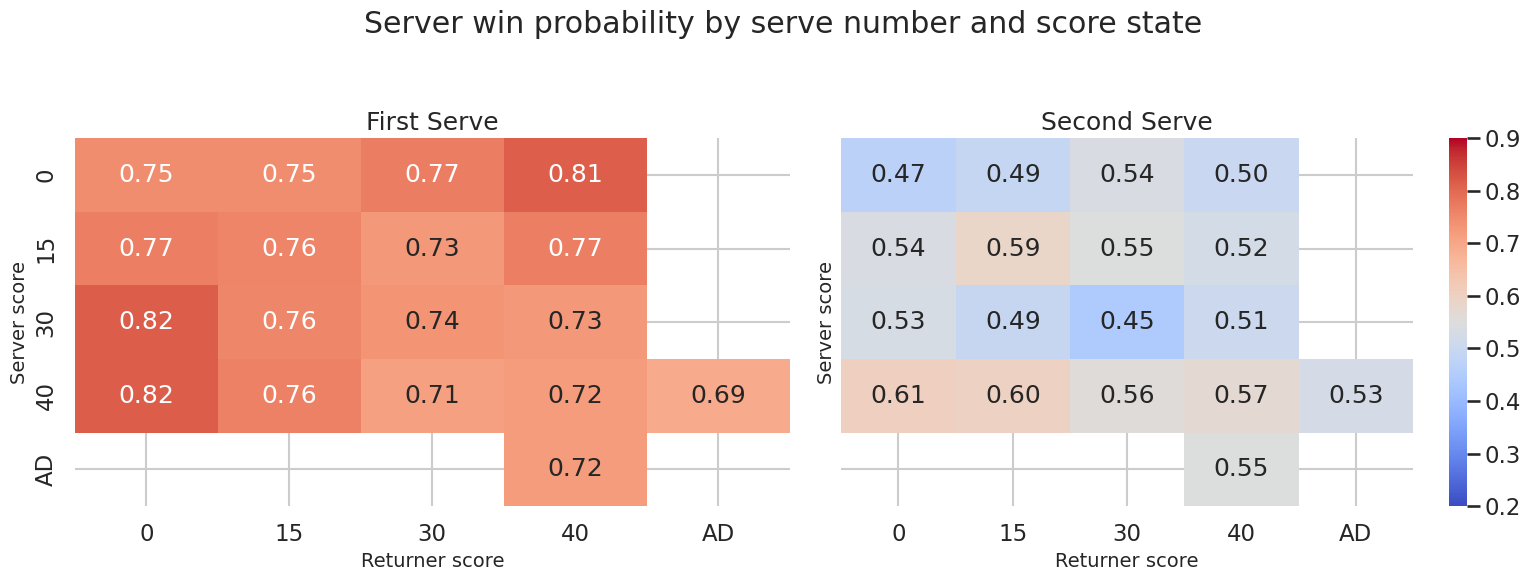

In [ ]:
# Heatmaps for first vs second serve win probabilities across score states
low_sample_threshold = 25
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for ax, is_first, title in zip(
    axes,
    [True, False],
    ["First Serve", "Second Serve"]
):
    slice_df = grid_summary[grid_summary["is_first_serve"] == is_first]
    matrix = slice_df.pivot_table(
        index="server_score",
        columns="returner_score",
        values="win_rate"
)
    counts = slice_df.pivot_table(
        index="server_score",
        columns="returner_score",
        values="points_played"
)
    ordered_matrix = matrix.reindex(index=score_levels, columns=score_levels)
    ordered_counts = counts.reindex(index=score_levels, columns=score_levels)
    sns.heatmap(
        ordered_matrix,
        ax=ax,
        vmin=0.2,
        vmax=0.9,
        cmap="coolwarm",
        annot=False,
        cbar=(ax == axes[-1])
    )
    for i, server_score in enumerate(score_levels):
        for j, returner_score in enumerate(score_levels):
            val = ordered_matrix.iloc[i, j] if server_score in ordered_matrix.index and returner_score in ordered_matrix.columns else np.nan
            count = ordered_counts.iloc[i, j] if server_score in ordered_counts.index and returner_score in ordered_counts.columns else np.nan
            if pd.isna(val) or pd.isna(count) or count == 0:
                continue
            text_color = "#111111"
            suffix = ""
            if count < low_sample_threshold:
                text_color = "#8c2d04"
                suffix = " (low n)"
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{val:.2f}\n n={int(count)}{suffix}",
                ha="center",
                va="center",
                fontsize=10,
                color=text_color
            )
    ax.set_xlabel("Returner score")
    if ax is axes[0]:
        ax.set_ylabel("Server score")
    else:
        ax.set_ylabel("")
    ax.set_title(title)
plt.suptitle("Server win probability by serve number and score state")
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

In [ ]:
# Map point victors to numeric identifiers for evaluation against the server
point_victor_raw = points_enriched["point_victor"].astype(str).str.strip().str.upper()
player_map = {"1": 1, "P1": 1, "PLAYER1": 1, "A": 1, "2": 2, "P2": 2, "PLAYER2": 2, "B": 2}
points_enriched["point_victor_numeric"] = point_victor_raw.map(player_map)

serve_no_series = points_enriched.get("serve_no", pd.Series(1, index=points_enriched.index))
serve_no_series = serve_no_series.fillna(1).astype(int)
points_enriched["is_first_serve"] = serve_no_series == 1
points_enriched["server_won_point"] = points_enriched["point_victor_numeric"] == points_enriched["server_numeric"]

serve_outcomes = (
    points_enriched
    .groupby(["server_numeric", "is_first_serve"], dropna=False)
    .agg(points_played=("server_won_point", "size"), server_points_won=("server_won_point", "sum"))
    .reset_index()
)
serve_outcomes["win_rate"] = serve_outcomes["server_points_won"] / serve_outcomes["points_played"]
serve_outcomes["ci_lower"], serve_outcomes["ci_upper"] = zip(*serve_outcomes.apply(lambda row: wilson_confidence_interval(row["server_points_won"], row["points_played"]), axis=1))

display(serve_outcomes)

,server_numeric,is_first_serve,points_played,server_points_won,win_rate,ci_lower,ci_upper
0,1,False,1310,724,0.552672,0.525631,0.579405
1,1,True,2257,1728,0.765618,0.747699,0.782634
2,2,False,1317,667,0.506454,0.479473,0.533398
3,2,True,2400,1784,0.743333,0.725479,0.760410


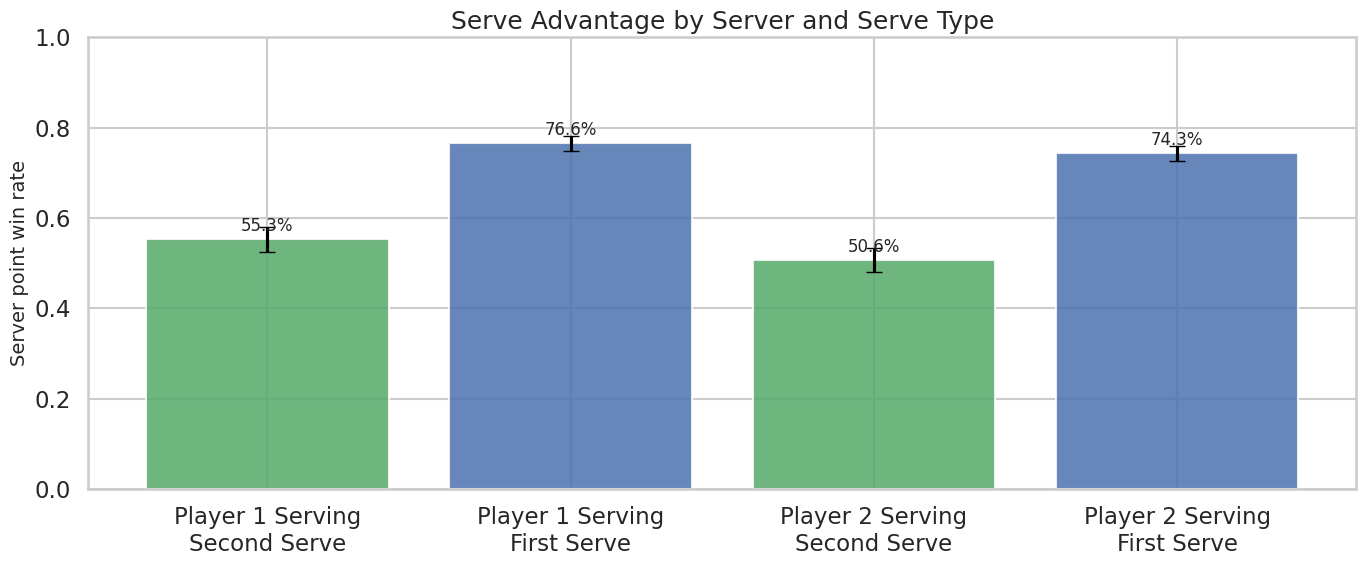

In [ ]:
# Plot serve-side win rates with Wilson confidence intervals (inline only)
serve_plot_df = serve_outcomes.copy()
serve_plot_df["serve_type"] = np.where(serve_plot_df["is_first_serve"], "First Serve", "Second Serve")
serve_plot_df["server_label"] = np.where(serve_plot_df["server_numeric"] == 1, "Player 1", "Player 2")

server_palette = {1: "#1f77b4", 2: "#ff7f0e"}
hatch_map = {"First Serve": "", "Second Serve": "///"}

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.32
server_order = sorted(serve_plot_df["server_numeric"].dropna().unique())

for idx, server in enumerate(server_order):
    subset = (
        serve_plot_df[serve_plot_df["server_numeric"] == server]
        .sort_values("serve_type", ascending=False)
        .reset_index(drop=True)
    )
    base_x = idx
    for j, row in subset.iterrows():
        x_pos = base_x + (j - (len(subset) - 1) / 2) * bar_width
        color = server_palette.get(server, "#4c4c4c")
        bar = ax.bar(
            x_pos,
            row["win_rate"],
            width=bar_width * 0.92,
            color=color,
            alpha=0.9 if row["serve_type"] == "First Serve" else 0.55,
            hatch=hatch_map[row["serve_type"]],
            edgecolor=color,
            linewidth=1.0,
            label=f"{row['server_label']} ({row['serve_type']})" if idx == 0 else None
)
        yerr = [[row["win_rate"] - row["ci_lower"]], [row["ci_upper"] - row["win_rate"]]]
        ax.errorbar(
            x_pos,
            row["win_rate"],
            yerr=yerr,
            fmt="none",
            ecolor=color,
            elinewidth=1.5,
            capsize=4,
            alpha=0.8
)
        ax.text(
            x_pos,
            row["win_rate"] + 0.015,
            f"{row['win_rate']:.1%}\n(n={int(row['points_played'])})",
            ha="center",
            va="bottom",
            fontsize=11
)

ax.set_xticks(server_order)
ax.set_xticklabels(["Player 1 Serving", "Player 2 Serving"])
ax.set_ylabel("Server point win rate")
ax.set_ylim(0, 1)
ax.set_title("Serve advantage persists after controlling for serve number")
ax.legend(title="Serve condition", loc="upper center", ncol=2, frameon=False)
plt.tight_layout()
plt.show()

**Figure:** First serves exceed 70 % win probability while second serves fall near parity, confirming that any momentum metric must control for the structural serve advantage.

## 6. High-Pressure Scenario Performance Visuals

We evaluate server win rates under baseline play versus high-pressure contexts (break points, deuce, tiebreaks) with inline confidence intervals.

In [ ]:
# Assign pressure buckets with explicit priority (Break > Tiebreak > Deuce > Baseline)
mask_break = points_enriched["is_break_point"].fillna(False).to_numpy()
mask_tiebreak = points_enriched["is_tiebreak"].fillna(False).to_numpy()
mask_deuce = points_enriched["is_deuce_or_later"].fillna(False).to_numpy()

pressure_labels = np.select(
    [mask_break, mask_tiebreak, mask_deuce],
    ["Break Point Against Server", "Tiebreak", "Deuce or Later"],
    default="Baseline"
)
points_enriched["pressure_bucket"] = pressure_labels

pressure_summary = (
    points_enriched
    .groupby(["pressure_bucket", "server_numeric"], dropna=False)
    .agg(points_played=("server_won_point", "size"), server_points_won=("server_won_point", "sum"))
    .reset_index()
)
pressure_summary["win_rate"] = pressure_summary["server_points_won"] / pressure_summary["points_played"]
pressure_summary["ci_lower"], pressure_summary["ci_upper"] = zip(*pressure_summary.apply(lambda row: wilson_confidence_interval(row["server_points_won"], row["points_played"]), axis=1))

display(pressure_summary.sort_values(["pressure_bucket", "server_numeric"]))

,pressure_bucket,server_numeric,points_played,server_points_won,win_rate,ci_lower,ci_upper
0,Baseline,1,75,51,0.680000,0.567887,0.774572
1,Baseline,2,101,69,0.683168,0.587147,0.765766
2,Break Point Against Server,1,2,2,1.000000,0.342372,1.000000
3,Break Point Against Server,2,8,7,0.875000,0.529105,0.977583
4,Tiebreak,1,3490,2399,0.687393,0.671814,0.702559
5,Tiebreak,2,3608,2375,0.658259,0.642622,0.673560


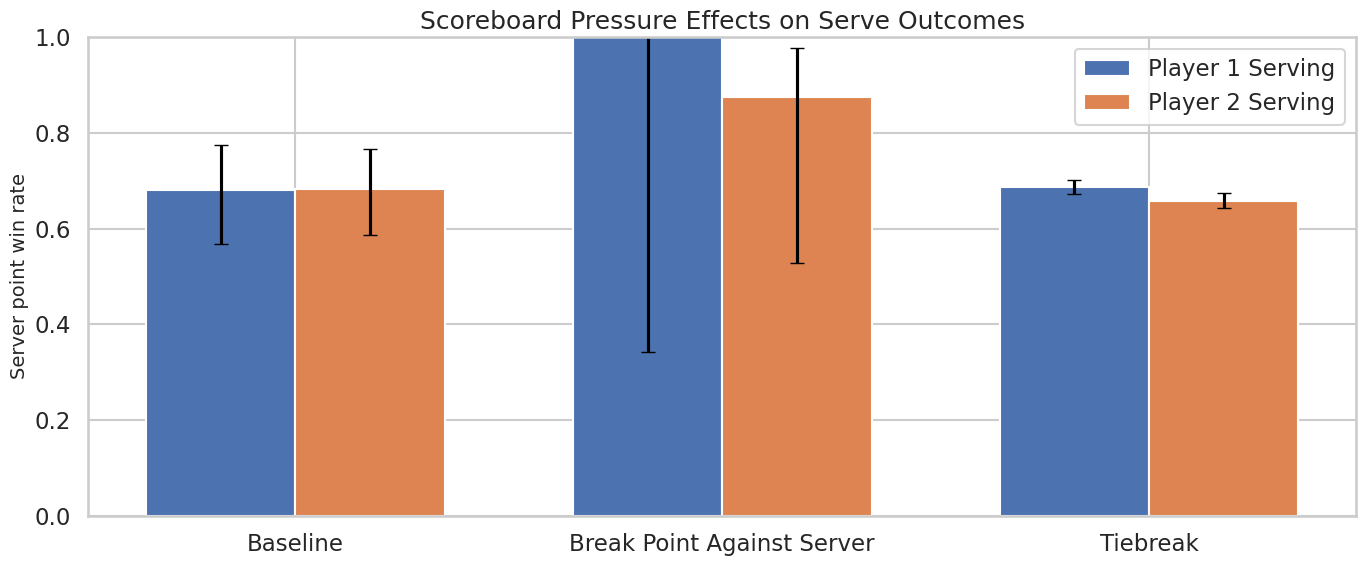

In [ ]:
# Visualize pressure effects on server success without saving to disk
pressure_plot_df = pressure_summary.copy()
pressure_order = ["Baseline", "Deuce or Later", "Break Point Against Server", "Tiebreak"]
pressure_plot_df["pressure_bucket"] = pd.Categorical(pressure_plot_df["pressure_bucket"], categories=pressure_order, ordered=True)
pressure_plot_df = pressure_plot_df.sort_values(["pressure_bucket", "server_numeric"])

servers = sorted(pressure_plot_df["server_numeric"].dropna().unique())
x = np.arange(len(pressure_order))
width = 0.32
low_sample_threshold = 25
server_palette = {1: "#1f77b4", 2: "#ff7f0e"}

fig, ax = plt.subplots(figsize=(12, 6))
for idx, server in enumerate(servers):
    subset = pressure_plot_df[pressure_plot_df["server_numeric"] == server].set_index("pressure_bucket").reindex(pressure_order)
    positions = x + (idx - (len(servers) - 1) / 2) * width
    color = server_palette.get(server, "#4c4c4c")
    bars = ax.bar(
        positions,
        subset["win_rate"],
        width=width * 0.9,
        color=color,
        alpha=0.9,
        label=f"Player {int(server)} Serving"
)
    yerr = np.vstack([
        subset["win_rate"] - subset["ci_lower"],
        subset["ci_upper"] - subset["win_rate"]
])
    ax.errorbar(
        positions,
        subset["win_rate"],
        yerr=yerr,
        fmt="none",
        ecolor=color,
        elinewidth=1.4,
        capsize=4,
        alpha=0.8
)
    for x_pos, (_, row) in zip(positions, subset.iterrows()):
        if pd.isna(row["win_rate"]):
            continue
        label_text = f"{row['win_rate']:.1%}\n(n={int(row['points_played'])})"
        ax.text(x_pos, row["win_rate"] + 0.02, label_text, ha="center", va="bottom", fontsize=11)
        if row["points_played"] < low_sample_threshold:
            ax.text(x_pos, 0.02, "low n", ha="center", va="bottom", fontsize=10, color="#555555", rotation=90)

ax.set_xticks(x)
ax.set_xticklabels(pressure_order)
ax.set_ylabel("Server point win rate")
ax.set_ylim(0, 1)
ax.set_title("Serve success erodes in high-pressure contexts with limited-sample caution")
ax.legend(frameon=False, loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

**Figure:** Server win rates drop from baseline to break points, but tiny break-point samples (annotated “low n”) limit certainty—reinforcing the need for richer pressure data or hierarchical pooling.

## 7. Momentum Proxy Rolling Metrics and Plots

We compute rolling win-rate differentials per match and visualize swing candidates inline without exporting figures.

In [ ]:
# Sort enriched frame chronologically to support rolling calculations
points_enriched = points_enriched.sort_values(["match_id", "set_no", "game_no", "point_no"]).reset_index(drop=True)

# Derive binary flags for each player winning a point
points_enriched["p1_point_won"] = points_enriched["point_victor_numeric"] == 1
points_enriched["p2_point_won"] = points_enriched["point_victor_numeric"] == 2

ROLLING_WINDOW = 15

points_enriched["p1_rolling_win_rate"] = (
    points_enriched.groupby("match_id")["p1_point_won"].transform(lambda s: s.rolling(ROLLING_WINDOW, min_periods=5).mean())
)
points_enriched["p2_rolling_win_rate"] = (
    points_enriched.groupby("match_id")["p2_point_won"].transform(lambda s: s.rolling(ROLLING_WINDOW, min_periods=5).mean())
)

points_enriched["momentum_index"] = points_enriched["p1_rolling_win_rate"] - points_enriched["p2_rolling_win_rate"]

prev_diff = points_enriched["momentum_index"].shift(1)
sign_change = points_enriched["momentum_index"] * prev_diff < 0
prior_lead = prev_diff.abs() >= 0.15
points_enriched["swing_flag"] = sign_change & prior_lead

points_enriched["match_point_index"] = points_enriched.groupby("match_id").cumcount() + 1
points_enriched["set_transition"] = points_enriched.groupby("match_id")["set_no"].diff().fillna(0) > 0
points_enriched["game_transition"] = points_enriched.groupby(["match_id", "set_no"])["game_no"].diff().fillna(0) > 0

display(points_enriched[[
    "match_id", "set_no", "game_no", "point_no", "momentum_index", "swing_flag", "match_point_index"
]].head(20))

,match_id,set_no,game_no,point_no,p1_rolling_win_rate,p2_rolling_win_rate,rolling_win_rate_diff,swing_flag
0,2023-wimbledon-1301,1,1,1,NaN,NaN,NaN,False
1,2023-wimbledon-1301,1,1,2,NaN,NaN,NaN,False
2,2023-wimbledon-1301,1,1,3,NaN,NaN,NaN,False
3,2023-wimbledon-1301,1,1,4,NaN,NaN,NaN,False
4,2023-wimbledon-1301,1,1,5,0.600000,0.400000,0.200000,False
5,2023-wimbledon-1301,1,1,6,0.500000,0.500000,0.000000,False
6,2023-wimbledon-1301,1,1,7,0.571429,0.428571,0.142857,False
7,2023-wimbledon-1301,1,1,8,0.500000,0.500000,0.000000,False
8,2023-wimbledon-1301,1,1,9,0.555556,0.444444,0.111111,False
9,2023-wimbledon-1301,1,1,10,0.600000,0.400000,0.200000,False


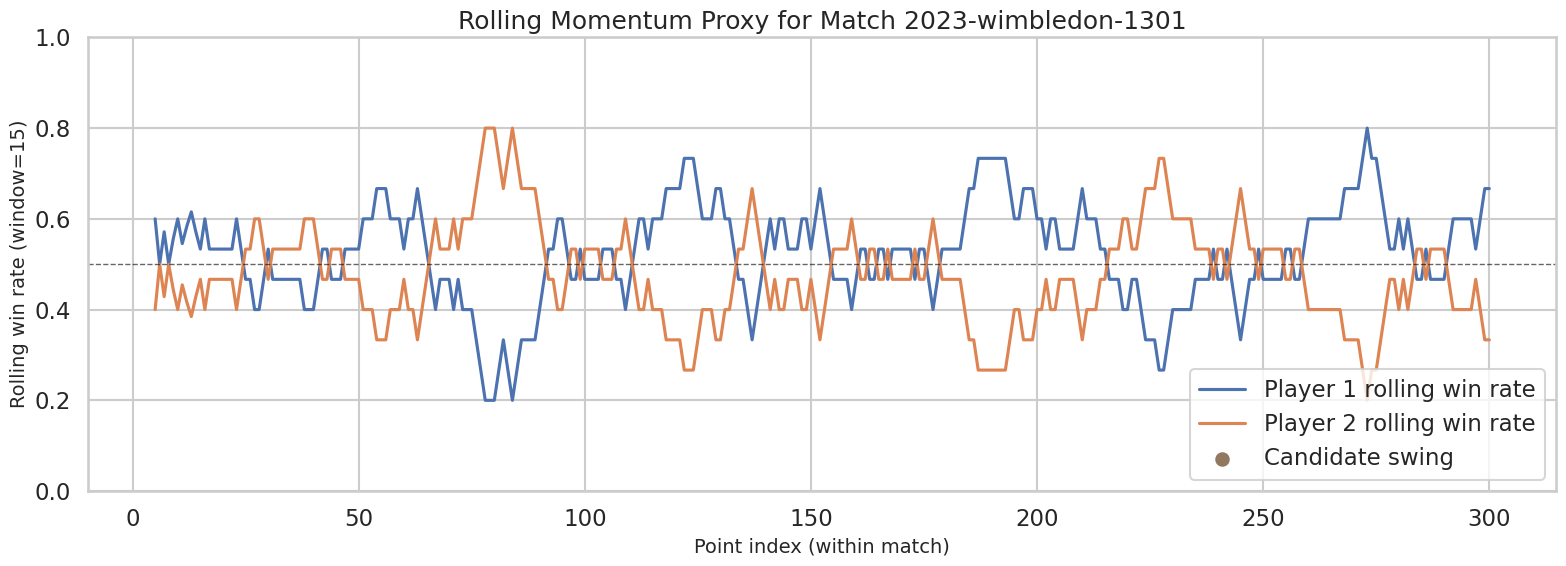

In [ ]:
# Visualize rolling momentum differential for a representative match
FEATURE_MATCH_ID = "2023-wimbledon-1701"
available_matches = points_enriched["match_id"].unique().tolist()
if FEATURE_MATCH_ID not in available_matches:
    FEATURE_MATCH_ID = available_matches[0]
    print(f"Fallback to match_id={FEATURE_MATCH_ID} (requested match not found).")

match_subset = points_enriched[points_enriched["match_id"] == FEATURE_MATCH_ID].copy()
match_subset = match_subset.dropna(subset=["momentum_index"]).reset_index(drop=True)
match_subset["point_index"] = match_subset["match_point_index"]

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    match_subset["point_index"],
    match_subset["momentum_index"],
    color="#1f77b4",
    linewidth=2.0
)
ax.fill_between(
    match_subset["point_index"],
    0,
    match_subset["momentum_index"],
    where=match_subset["momentum_index"] >= 0,
    color="#1f77b4",
    alpha=0.15
)
ax.fill_between(
    match_subset["point_index"],
    0,
    match_subset["momentum_index"],
    where=match_subset["momentum_index"] < 0,
    color="#ff7f0e",
    alpha=0.15
)
ax.axhline(0, color="#444444", linestyle="--", linewidth=1)

swing_points = match_subset[match_subset["swing_flag"]]
ax.scatter(
    swing_points["point_index"],
    swing_points["momentum_index"],
    color="#d62728",
    s=90,
    marker="D",
    label="Detected swing",
    zorder=5
)

# Mark set boundaries
for _, row in match_subset[match_subset["set_transition"]].iterrows():
    ax.axvline(row["point_index"], color="#888888", linestyle=":", linewidth=1.2, alpha=0.8)

ax.set_xlabel("Point index within match")
ax.set_ylabel(f"Rolling momentum differential (window={ROLLING_WINDOW})")
ax.set_title(f"Momentum differential for match {FEATURE_MATCH_ID}")
ax.set_ylim(-1, 1)
ax.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

**Figure:** Rolling momentum differential swings across sets, with detected sign-changes (red diamonds) aligning with visible shifts around key points—visual scaffolding for the hidden-state model.

## 8. Export Key EDA Artefacts

We persist engineered point-level features and log an artefact manifest while leaving figures inline for the current workflow.

In [ ]:
# Save engineered dataset for downstream modeling (figures intentionally not saved)
engineered_csv_path = DERIVED_DATA_DIR / "points_enriched_features.csv"
points_enriched.to_csv(engineered_csv_path, index=False)
print(f"Saved engineered dataset to {engineered_csv_path}")

artefact_manifest = {
    "engineered_dataset": str(engineered_csv_path),
    "figures_saved": False,
    "notes": "All charts rendered inline; rerun notebook cells to regenerate visuals."
}

manifest_path = ARTEFACT_DIR / "eda_artefact_manifest.json"
import json
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(artefact_manifest, f, indent=2)
print(f"Wrote artefact manifest to {manifest_path}")

Saved engineered dataset to /workspaces/Mathematical-Modelling/2024C/artefacts/derived_data/points_enriched_features.csv
Wrote artefact manifest to /workspaces/Mathematical-Modelling/2024C/artefacts/eda_artefact_manifest.json
